# LangGraph Retrieval Agent

We can implement
[Retrieval Agents](https://js.langchain.com/docs/tutorials/rag/)
in [LangGraph](https://js.langchain.com/docs/langgraph).

## Setup

### Load env vars

Add a `.env` variable in the root of the `./examples` folder with your
variables.

In [1]:
// import dotenv from 'dotenv';

// dotenv.config();

### Install dependencies

```bash
npm install cheerio zod zod-to-json-schema langchain @langchain/openai @langchain/core @langchain/community @langchain/textsplitters
```

## Retriever

In [2]:
import { CheerioWebBaseLoader } from "@langchain/community/document_loaders/web/cheerio";
import { RecursiveCharacterTextSplitter } from "@langchain/textsplitters";
import { MemoryVectorStore } from "langchain/vectorstores/memory";
import { OpenAIEmbeddings } from "@langchain/openai";

const urls = [
  "https://lilianweng.github.io/posts/2023-06-23-agent/",
  "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
  "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
];

const docs = await Promise.all(
  urls.map((url) => new CheerioWebBaseLoader(url).load()),
);
const docsList = docs.flat();

const textSplitter = new RecursiveCharacterTextSplitter({
  chunkSize: 500,
  chunkOverlap: 50,
});
const docSplits = await textSplitter.splitDocuments(docsList);

// Add to vectorDB
const vectorStore = await MemoryVectorStore.fromDocuments(
  docSplits,
  new OpenAIEmbeddings(),
);

const retriever = vectorStore.asRetriever();

## Agent state

We will define a graph.

You may pass a custom `state` object to the graph, or use a simple list of
`messages`.

Our state will be a list of `messages`.

Each node in our graph will append to it.

In [3]:
import { Annotation } from "@langchain/langgraph";
import { BaseMessage } from "@langchain/core/messages";

const GraphState = Annotation.Root({
  messages: Annotation<BaseMessage[]>({
    reducer: (x, y) => x.concat(y),
    default: () => [],
  })
})

In [4]:
import { createRetrieverTool } from "langchain/tools/retriever";
import { ToolNode } from "@langchain/langgraph/prebuilt";

const tool = createRetrieverTool(
  retriever,
  {
    name: "retrieve_blog_posts",
    description:
      "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.",
  },
);
const tools = [tool];

const toolNode = new ToolNode<typeof GraphState.State>(tools);

## Nodes and Edges

Each node will -

1/ Either be a function or a runnable.

2/ Modify the `state`.

The edges choose which node to call next.

We can lay out an agentic RAG graph like this:

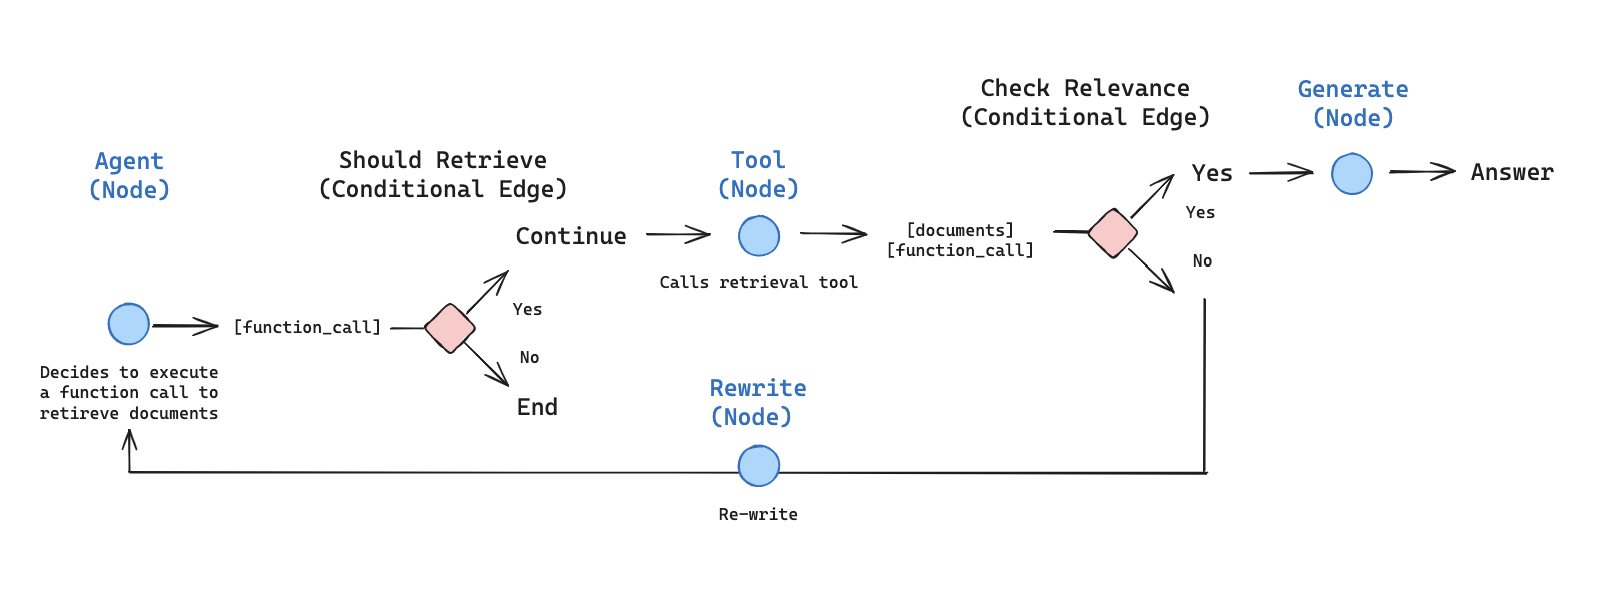

### Edges

In [5]:
import { END } from "@langchain/langgraph";
import { pull } from "langchain/hub";
import { z } from "zod";
import { ChatPromptTemplate } from "@langchain/core/prompts";
import { ChatOpenAI } from "@langchain/openai";
import { AIMessage, BaseMessage } from "@langchain/core/messages";

/**
 * Decides whether the agent should retrieve more information or end the process.
 * This function checks the last message in the state for a function call. If a tool call is
 * present, the process continues to retrieve information. Otherwise, it ends the process.
 * @param {typeof GraphState.State} state - The current state of the agent, including all messages.
 * @returns {string} - A decision to either "continue" the retrieval process or "end" it.
 */
function shouldRetrieve(state: typeof GraphState.State): string {
  const { messages } = state;
  console.log("---DECIDE TO RETRIEVE---");
  const lastMessage = messages[messages.length - 1];

  if ("tool_calls" in lastMessage && Array.isArray(lastMessage.tool_calls) && lastMessage.tool_calls.length) {
    console.log("---DECISION: RETRIEVE---");
    return "retrieve";
  }
  // If there are no tool calls then we finish.
  return END;
}

/**
 * Determines whether the Agent should continue based on the relevance of retrieved documents.
 * This function checks if the last message in the conversation is of type FunctionMessage, indicating
 * that document retrieval has been performed. It then evaluates the relevance of these documents to the user's
 * initial question using a predefined model and output parser. If the documents are relevant, the conversation
 * is considered complete. Otherwise, the retrieval process is continued.
 * @param {typeof GraphState.State} state - The current state of the agent, including all messages.
 * @returns {Promise<Partial<typeof GraphState.State>>} - The updated state with the new message added to the list of messages.
 */
async function gradeDocuments(state: typeof GraphState.State): Promise<Partial<typeof GraphState.State>> {
  console.log("---GET RELEVANCE---");

  const { messages } = state;
  const tool = {
    name: "give_relevance_score",
    description: "Give a relevance score to the retrieved documents.",
    schema: z.object({
      binaryScore: z.string().describe("Relevance score 'yes' or 'no'"),
    })
  }

  const prompt = ChatPromptTemplate.fromTemplate(
    `You are a grader assessing relevance of retrieved docs to a user question.
  Here are the retrieved docs:
  \n ------- \n
  {context} 
  \n ------- \n
  Here is the user question: {question}
  If the content of the docs are relevant to the users question, score them as relevant.
  Give a binary score 'yes' or 'no' score to indicate whether the docs are relevant to the question.
  Yes: The docs are relevant to the question.
  No: The docs are not relevant to the question.`,
  );

  const model = new ChatOpenAI({
    model: "gpt-4o",
    temperature: 0,
  }).bindTools([tool], {
    tool_choice: tool.name,
  });

  const chain = prompt.pipe(model);

  const lastMessage = messages[messages.length - 1];

  const score = await chain.invoke({
    question: messages[0].content as string,
    context: lastMessage.content as string,
  });

  return {
    messages: [score]
  };
}

/**
 * Check the relevance of the previous LLM tool call.
 *
 * @param {typeof GraphState.State} state - The current state of the agent, including all messages.
 * @returns {string} - A directive to either "yes" or "no" based on the relevance of the documents.
 */
function checkRelevance(state: typeof GraphState.State): string {
  console.log("---CHECK RELEVANCE---");

  const { messages } = state;
  const lastMessage = messages[messages.length - 1];
  if (!("tool_calls" in lastMessage)) {
    throw new Error("The 'checkRelevance' node requires the most recent message to contain tool calls.")
  }
  const toolCalls = (lastMessage as AIMessage).tool_calls;
  if (!toolCalls || !toolCalls.length) {
    throw new Error("Last message was not a function message");
  }

  if (toolCalls[0].args.binaryScore === "yes") {
    console.log("---DECISION: DOCS RELEVANT---");
    return "yes";
  }
  console.log("---DECISION: DOCS NOT RELEVANT---");
  return "no";
}

// Nodes

/**
 * Invokes the agent model to generate a response based on the current state.
 * This function calls the agent model to generate a response to the current conversation state.
 * The response is added to the state's messages.
 * @param {typeof GraphState.State} state - The current state of the agent, including all messages.
 * @returns {Promise<Partial<typeof GraphState.State>>} - The updated state with the new message added to the list of messages.
 */
async function agent(state: typeof GraphState.State): Promise<Partial<typeof GraphState.State>> {
  console.log("---CALL AGENT---");
  
  const { messages } = state;
  // Find the AIMessage which contains the `give_relevance_score` tool call,
  // and remove it if it exists. This is because the agent does not need to know
  // the relevance score.
  const filteredMessages = messages.filter((message) => {
    if ("tool_calls" in message && Array.isArray(message.tool_calls) && message.tool_calls.length > 0) {
      return message.tool_calls[0].name !== "give_relevance_score";
    }
    return true;
  });

  const model = new ChatOpenAI({
    model: "gpt-4o",
    temperature: 0,
    streaming: true,
  }).bindTools(tools);

  const response = await model.invoke(filteredMessages);
  return {
    messages: [response],
  };
}

/**
 * Transform the query to produce a better question.
 * @param {typeof GraphState.State} state - The current state of the agent, including all messages.
 * @returns {Promise<Partial<typeof GraphState.State>>} - The updated state with the new message added to the list of messages.
 */
async function rewrite(state: typeof GraphState.State): Promise<Partial<typeof GraphState.State>> {
  console.log("---TRANSFORM QUERY---");

  const { messages } = state;
  const question = messages[0].content as string;
  const prompt = ChatPromptTemplate.fromTemplate(
    `Look at the input and try to reason about the underlying semantic intent / meaning. \n 
Here is the initial question:
\n ------- \n
{question} 
\n ------- \n
Formulate an improved question:`,
  );

  // Grader
  const model = new ChatOpenAI({
    model: "gpt-4o",
    temperature: 0,
    streaming: true,
  });
  const response = await prompt.pipe(model).invoke({ question });
  return {
    messages: [response],
  };
}

/**
 * Generate answer
 * @param {typeof GraphState.State} state - The current state of the agent, including all messages.
 * @returns {Promise<Partial<typeof GraphState.State>>} - The updated state with the new message added to the list of messages.
 */
async function generate(state: typeof GraphState.State): Promise<Partial<typeof GraphState.State>> {
  console.log("---GENERATE---");
  
  const { messages } = state;
  const question = messages[0].content as string;
  // Extract the most recent ToolMessage
  const lastToolMessage = messages.slice().reverse().find((msg) => msg._getType() === "tool");
  if (!lastToolMessage) {
    throw new Error("No tool message found in the conversation history");
  }

  const docs = lastToolMessage.content as string;

  const prompt = await pull<ChatPromptTemplate>("rlm/rag-prompt");

  const llm = new ChatOpenAI({
    model: "gpt-4o",
    temperature: 0,
    streaming: true,
  });

  const ragChain = prompt.pipe(llm);

  const response = await ragChain.invoke({
    context: docs,
    question,
  });

  return {
    messages: [response],
  };
}

## Graph

- Start with an agent, `callModel`
- Agent make a decision to call a function
- If so, then `action` to call tool (retriever)
- Then call agent with the tool output added to messages (`state`)

In [6]:
import { StateGraph } from "@langchain/langgraph";

// Define the graph
const workflow = new StateGraph(GraphState)
  // Define the nodes which we'll cycle between.
  .addNode("agent", agent)
  .addNode("retrieve", toolNode)
  .addNode("gradeDocuments", gradeDocuments)
  .addNode("rewrite", rewrite)
  .addNode("generate", generate);

In [7]:
import { START } from "@langchain/langgraph";

// Call agent node to decide to retrieve or not
workflow.addEdge(START, "agent");

// Decide whether to retrieve
workflow.addConditionalEdges(
  "agent",
  // Assess agent decision
  shouldRetrieve,
);

workflow.addEdge("retrieve", "gradeDocuments");

// Edges taken after the `action` node is called.
workflow.addConditionalEdges(
  "gradeDocuments",
  // Assess agent decision
  checkRelevance,
  {
    // Call tool node
    yes: "generate",
    no: "rewrite", // placeholder
  },
);

workflow.addEdge("generate", END);
workflow.addEdge("rewrite", "agent");

// Compile
const app = workflow.compile();

In [8]:
import { HumanMessage } from "@langchain/core/messages";

const inputs = {
  messages: [
    new HumanMessage(
      "What are the types of agent memory based on Lilian Weng's blog post?",
    ),
  ],
};
let finalState;
for await (const output of await app.stream(inputs)) {
  for (const [key, value] of Object.entries(output)) {
    const lastMsg = output[key].messages[output[key].messages.length - 1];
    console.log(`Output from node: '${key}'`);
    console.dir({
      type: lastMsg._getType(),
      content: lastMsg.content,
      tool_calls: lastMsg.tool_calls,
    }, { depth: null });
    console.log("---\n");
    finalState = value;
  }
}

console.log(JSON.stringify(finalState, null, 2));

---CALL AGENT---
---DECIDE TO RETRIEVE---
---DECISION: RETRIEVE---
Output from node: 'agent'
{
  type: 'ai',
  content: '',
  tool_calls: [
    {
      name: 'retrieve_blog_posts',
      args: { query: 'types of agent memory' },
      id: 'call_adLYkV7T2ry1EZFboT0jPuwn',
      type: 'tool_call'
    }
  ]
}
---

Output from node: 'retrieve'
{
  type: 'tool',
  content: 'Agent System Overview\n' +
    '                \n' +
    '                    Component One: Planning\n' +
    '                        \n' +
    '                \n' +
    '                    Task Decomposition\n' +
    '                \n' +
    '                    Self-Reflection\n' +
    '                \n' +
    '                \n' +
    '                    Component Two: Memory\n' +
    '                        \n' +
    '                \n' +
    '                    Types of Memory\n' +
    '                \n' +
    '                    Maximum Inner Product Search (MIPS)\n' +
    '\n' +
    'Memory stream